# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_155  A0A075B6I1        17.534
Sample_036  O00187;O00187-2   16.198
Sample_057  P05534            18.972
Sample_165  P01042-2          20.598
Sample_018  Q15828            15.782
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups          
Sample_156  Q9UN70;Q9UN70-2            15.558
Sample_161  P20338                     16.662
Sample_103  Q5VV43;Q5VV43-2;Q5VV43-4   16.926
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.584
            A0A075B6Q5                 12.407
            A0A075B6R2                 14.847
            A0A075B6S5                 13.593
            A0A087WSY4                 12.576
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.302
            Q9UI40;Q9UI40-2            12.703
            Q9UIW2                     12.997
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.912
            Q9UP79                     13.572
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.936,15.050,16.842,19.863,15.911,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.750,19.067,...,15.528,15.576,13.823,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.829,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.885,17.705,17.039,15.972,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.146,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.654,15.345,17.084,18.708,14.249,19.433,11.612,10.556
Sample_207,15.739,16.877,15.469,16.898,13.537,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.379,13.086,13.946,12.301,12.528,12.673,13.810,12.763,13.000,12.338
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.165,19.067,16.127,...,11.991,12.913,14.294,14.303,12.616,13.124,12.410,13.359,11.672,12.614
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,10.844,13.189,11.206,13.089,11.973,12.942,12.020,13.419,13.570,13.630
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.769,12.975,12.364,12.323,13.083,12.159,12.487,13.444,13.086,13.039
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.917,11.957,13.374,12.616,13.528,12.950,13.939,12.371,13.507,11.838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.076,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 333.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.99it/s]

100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.23it/s]

100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.97it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.68it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.78it/s]

100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.29it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.53it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.85it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.80it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.37it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.87it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.61it/s]

100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.10it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.96it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.78it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.55it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.96it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.79it/s]

100%|██████████| 8/8 [00:02<00:00,  2.54it/s]

100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.51it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.25it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.14it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.93it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.82it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.64it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.54it/s]

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.14it/s]

 30%|███       | 3/10 [00:00<00:01,  6.67it/s]

 40%|████      | 4/10 [00:00<00:01,  5.63it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.89it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.69it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.59it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.59it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.53it/s]

100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

100%|██████████| 10/10 [00:02<00:00,  4.79it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.15it/s]

 36%|███▋      | 4/11 [00:00<00:00,  8.02it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.85it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.63it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  7.16it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.69it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.39it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.29it/s]

100%|██████████| 11/11 [00:01<00:00,  5.60it/s]

100%|██████████| 11/11 [00:01<00:00,  6.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.27it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.74it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.54it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.96it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.96it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.89it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.86it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.77it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.62it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.05it/s]

100%|██████████| 12/12 [00:02<00:00,  4.11it/s]

100%|██████████| 12/12 [00:02<00:00,  4.76it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.94it/s]

 31%|███       | 4/13 [00:00<00:01,  5.73it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.47it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.18it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.05it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.18it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.79it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.07it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.88it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.17it/s]

100%|██████████| 13/13 [00:02<00:00,  4.27it/s]

100%|██████████| 13/13 [00:02<00:00,  4.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.89it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.78it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.76it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.16it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.82it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.61it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.53it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.33it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.97it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.95it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.17it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.02it/s]

100%|██████████| 14/14 [00:03<00:00,  4.13it/s]

100%|██████████| 14/14 [00:03<00:00,  4.54it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.39it/s]

 20%|██        | 3/15 [00:00<00:01,  6.00it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.26it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.58it/s]

 40%|████      | 6/15 [00:01<00:02,  4.44it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.29it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.92it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.09it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.12it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.17it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.24it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.44it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.21it/s]

100%|██████████| 15/15 [00:03<00:00,  4.21it/s]

100%|██████████| 15/15 [00:03<00:00,  4.43it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.048 0.020          0.669 0.414       0.086   
2             0.005 0.004      0.041 0.012          0.696 0.131       0.528   
3             0.004 0.003      0.053 0.024          0.700 0.121       0.619   
4             0.005 0.004      0.049 0.018          0.709 0.110       0.624   
5             0.004 0.003      0.041 0.011          0.687 0.092       0.666   
6             0.006 0.006      0.048 0.016          0.802 0.081       0.805   
7             0.005 0.004      0.050 0.019          0.795 0.082       0.801   
8             0.006 0.006      0.053 0.016          0.793 0.089       0.787   
9             0.007 0.008      0.054 0.020          0.790 0.091       0.791   
10            0.003 0.001      0.032 0.006          0.792 0.089       0.788   
11            0.003 0.001      0.023 0.005          0.794 0.086       0.798   
12            0.003 0.001      0.034 0.005          0.813 0.088       0.804   
13            0.004 0.001      0.036 0.005          0.803 0.090       0.800   
14            0.004 0.000      0.039 0.011          0.798 0.093       0.795   
15            0.004 0.001      0.039 0.010          0.794 0.089       0.794   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.076   0.147 0.116                  0.536 0.035        0.844   
2          0.109   0.592 0.090                  0.675 0.065        0.721   
3          0.128   0.646 0.090                  0.705 0.071        0.780   
4          0.103   0.657 0.079                  0.714 0.063        0.802   
5          0.112   0.671 0.079                  0.720 0.065        0.798   
6          0.111   0.798 0.071                  0.828 0.058        0.891   
7          0.109   0.793 0.070                  0.824 0.058        0.888   
8          0.099   0.785 0.067                  0.816 0.056        0.887   
9          0.107   0.785 0.072                  0.816 0.060        0.887   
10         0.108   0.785 0.074                  0.816 0.062        0.889   
11         0.115   0.790 0.073                  0.821 0.061        0.896   
12         0.107   0.803 0.070                  0.832 0.058        0.905   
13         0.109   0.795 0.072                  0.826 0.059        0.904   
14         0.101   0.791 0.070                  0.821 0.058        0.903   
15         0.103   0.788 0.069                  0.819 0.058        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.820 0.089        210.000 0.000  
2          0.080                  0.686 0.098        210.000 0.000  
3          0.078                  0.714 0.097        210.000 0.000  
4          0.072                  0.762 0.094        210.000 0.000  
5          0.066                  0.755 0.092        210.000 0.000  
6          0.050                  0.860 0.063        210.000 0.000  
7          0.051                  0.858 0.064        210.000 0.000  
8          0.052                  0.855 0.067        210.000 0.000  
9          0.054                  0.858 0.065        210.000 0.000  
10         0.054                  0.864 0.064        210.000 0.000  
11         0.053                  0.879 0.057        210.000 0.000  
12         0.052                  0.893 0.052        210.000 0.000  
13         0.052                  0.892 0.053        210.000 0.000  
14         0.052                  0.891 0.052        210.000 0.000  
15         0.051                  0.891 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 515.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.70it/s]

100%|██████████| 2/2 [00:00<00:00,  7.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.85it/s]

100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

100%|██████████| 3/3 [00:00<00:00,  5.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.82it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.30it/s]

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.30it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.83it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.89it/s]

100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.60it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.77it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.48it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.22it/s]

100%|██████████| 6/6 [00:01<00:00,  4.20it/s]

100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.59it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.80it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.53it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.06it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.87it/s]

100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.19it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.80it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.68it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.36it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.34it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.15it/s]

100%|██████████| 8/8 [00:01<00:00,  4.13it/s]

100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.98it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.30it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.20it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.93it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.54it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.32it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.28it/s]

100%|██████████| 9/9 [00:01<00:00,  4.37it/s]

100%|██████████| 9/9 [00:01<00:00,  4.77it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  8.00it/s]

 30%|███       | 3/10 [00:00<00:01,  5.71it/s]

 40%|████      | 4/10 [00:00<00:01,  4.92it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.41it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.42it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.04it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.86it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.82it/s]

100%|██████████| 10/10 [00:02<00:00,  2.87it/s]

100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.08it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.37it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.58it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.38it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.43it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.38it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.47it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.64it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.86it/s]

100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.43it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.80it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.32it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.19it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.05it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.95it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.13it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.60it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.36it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.31it/s]

100%|██████████| 12/12 [00:04<00:00,  2.26it/s]

100%|██████████| 12/12 [00:04<00:00,  2.95it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.05it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.18it/s]

 31%|███       | 4/13 [00:01<00:03,  2.97it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.95it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.82it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.82it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.91it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.95it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.15it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.33it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.49it/s]

100%|██████████| 13/13 [00:04<00:00,  3.70it/s]

100%|██████████| 13/13 [00:04<00:00,  3.23it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.64it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.76it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.09it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.74it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.52it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.24it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.96it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.75it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.54it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.35it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.26it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.12it/s]

100%|██████████| 14/14 [00:05<00:00,  2.24it/s]

100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.75it/s]

 20%|██        | 3/15 [00:00<00:03,  3.09it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.68it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.52it/s]

 40%|████      | 6/15 [00:02<00:03,  2.44it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.59it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.71it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.66it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.84it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.01it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.07it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.07it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.16it/s]

100%|██████████| 15/15 [00:05<00:00,  3.36it/s]

100%|██████████| 15/15 [00:05<00:00,  2.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.007          0.107 0.279       0.011   
2             0.003 0.000      0.038 0.009          0.613 0.167       0.312   
3             0.003 0.000      0.039 0.010          0.640 0.127       0.513   
4             0.004 0.003      0.045 0.015          0.623 0.121       0.503   
5             0.006 0.005      0.056 0.018          0.691 0.097       0.571   
6             0.003 0.000      0.034 0.004          0.758 0.093       0.640   
7             0.002 0.000      0.022 0.003          0.754 0.079       0.743   
8             0.003 0.001      0.030 0.005          0.749 0.083       0.756   
9             0.006 0.005      0.054 0.017          0.754 0.080       0.744   
10            0.006 0.005      0.060 0.031          0.752 0.079       0.742   
11            0.006 0.005      0.050 0.022          0.751 0.073       0.745   
12            0.004 0.003      0.041 0.017          0.746 0.070       0.744   
13            0.005 0.004      0.055 0.021          0.774 0.083       0.769   
14            0.004 0.002      0.039 0.010          0.784 0.085       0.768   
15            0.005 0.004      0.055 0.022          0.781 0.084       0.768   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.019 0.050                  0.501 0.013        0.864   
2          0.112   0.400 0.109                  0.576 0.061        0.692   
3          0.119   0.559 0.097                  0.645 0.070        0.730   
4          0.117   0.547 0.093                  0.635 0.067        0.722   
5          0.106   0.619 0.088                  0.690 0.060        0.740   
6          0.115   0.687 0.083                  0.744 0.059        0.811   
7          0.098   0.744 0.064                  0.782 0.052        0.871   
8          0.093   0.749 0.067                  0.784 0.057        0.880   
9          0.093   0.745 0.064                  0.782 0.053        0.881   
10         0.102   0.742 0.065                  0.780 0.053        0.880   
11         0.101   0.743 0.063                  0.781 0.052        0.882   
12         0.100   0.740 0.063                  0.779 0.052        0.882   
13         0.107   0.766 0.069                  0.800 0.057        0.908   
14         0.095   0.771 0.069                  0.805 0.058        0.910   
15         0.096   0.770 0.067                  0.804 0.057        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.833 0.088        210.000 0.000  
2          0.086                  0.618 0.102        210.000 0.000  
3          0.073                  0.656 0.097        210.000 0.000  
4          0.071                  0.647 0.094        210.000 0.000  
5          0.069                  0.702 0.094        210.000 0.000  
6          0.066                  0.787 0.086        210.000 0.000  
7          0.046                  0.828 0.068        210.000 0.000  
8          0.048                  0.840 0.069        210.000 0.000  
9          0.047                  0.839 0.069        210.000 0.000  
10         0.046                  0.837 0.071        210.000 0.000  
11         0.044                  0.842 0.069        210.000 0.000  
12         0.043                  0.838 0.069        210.000 0.000  
13         0.040                  0.884 0.050        210.000 0.000  
14         0.040                  0.890 0.046        210.000 0.000  
15         0.040                  0.887 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1094.26it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 48.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.17it/s]

100%|██████████| 3/3 [00:00<00:00, 20.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 23.88it/s]

100%|██████████| 4/4 [00:00<00:00, 20.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.54it/s]

100%|██████████| 5/5 [00:00<00:00, 14.04it/s]

100%|██████████| 5/5 [00:00<00:00, 14.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.09it/s]

100%|██████████| 6/6 [00:00<00:00, 16.21it/s]

100%|██████████| 6/6 [00:00<00:00, 16.43it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.71it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 16.84it/s]

100%|██████████| 7/7 [00:00<00:00, 15.18it/s]

100%|██████████| 7/7 [00:00<00:00, 15.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.85it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.30it/s]

100%|██████████| 8/8 [00:00<00:00, 16.58it/s]

100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.50it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 16.54it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 15.23it/s]

100%|██████████| 9/9 [00:00<00:00, 13.55it/s]

100%|██████████| 9/9 [00:00<00:00, 14.57it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.60it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.33it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.47it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.81it/s]

100%|██████████| 10/10 [00:00<00:00, 14.06it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.93it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.57it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.91it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.94it/s]

100%|██████████| 11/11 [00:00<00:00, 15.24it/s]

100%|██████████| 11/11 [00:00<00:00, 15.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.96it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.86it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.21it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.81it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 14.09it/s]

100%|██████████| 12/12 [00:00<00:00, 14.18it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 25.70it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.00it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 17.10it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.42it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.90it/s]

100%|██████████| 13/13 [00:00<00:00, 15.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 25.10it/s]

 43%|████▎     | 6/14 [00:00<00:00, 19.17it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 14.50it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.60it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.21it/s]

100%|██████████| 14/14 [00:01<00:00, 13.76it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 24.09it/s]

 40%|████      | 6/15 [00:00<00:00, 20.52it/s]

 60%|██████    | 9/15 [00:00<00:00, 15.55it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 14.08it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 13.83it/s]

100%|██████████| 15/15 [00:00<00:00, 13.93it/s]

100%|██████████| 15/15 [00:01<00:00, 15.00it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.046 0.021          0.000 0.000       0.000   
2             0.005 0.004      0.044 0.014          0.738 0.218       0.192   
3             0.005 0.005      0.047 0.019          0.681 0.085       0.606   
4             0.004 0.003      0.048 0.017          0.693 0.089       0.643   
5             0.005 0.005      0.053 0.024          0.702 0.075       0.614   
6             0.004 0.003      0.048 0.019          0.691 0.078       0.613   
7             0.005 0.003      0.053 0.024          0.685 0.085       0.618   
8             0.004 0.002      0.046 0.021          0.680 0.088       0.610   
9             0.005 0.004      0.053 0.021          0.716 0.086       0.666   
10            0.006 0.005      0.054 0.020          0.714 0.082       0.689   
11            0.006 0.006      0.056 0.024          0.716 0.081       0.681   
12            0.005 0.004      0.055 0.023          0.719 0.079       0.680   
13            0.005 0.004      0.053 0.025          0.726 0.069       0.708   
14            0.006 0.005      0.055 0.025          0.723 0.070       0.706   
15            0.005 0.003      0.059 0.022          0.717 0.072       0.705   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.740   
2          0.094   0.291 0.123                  0.566 0.049        0.586   
3          0.116   0.634 0.086                  0.698 0.064        0.776   
4          0.112   0.661 0.082                  0.716 0.067        0.795   
5          0.111   0.649 0.078                  0.711 0.059        0.800   
6          0.110   0.644 0.079                  0.705 0.061        0.795   
7          0.112   0.642 0.081                  0.703 0.060        0.792   
8          0.117   0.636 0.087                  0.698 0.065        0.790   
9          0.114   0.683 0.080                  0.734 0.060        0.835   
10         0.113   0.696 0.082                  0.743 0.063        0.839   
11         0.113   0.692 0.078                  0.741 0.061        0.837   
12         0.114   0.693 0.080                  0.742 0.059        0.836   
13         0.118   0.711 0.075                  0.755 0.056        0.841   
14         0.120   0.708 0.076                  0.753 0.055        0.839   
15         0.117   0.704 0.073                  0.749 0.053        0.833   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.689 0.087        210.000 0.000  
2          0.069                  0.579 0.068        210.000 0.000  
3          0.060                  0.716 0.076        210.000 0.000  
4          0.060                  0.731 0.069        210.000 0.000  
5          0.057                  0.742 0.068        210.000 0.000  
6          0.056                  0.735 0.068        210.000 0.000  
7          0.057                  0.729 0.073        210.000 0.000  
8          0.058                  0.726 0.073        210.000 0.000  
9          0.050                  0.778 0.069        210.000 0.000  
10         0.051                  0.776 0.070        210.000 0.000  
11         0.053                  0.773 0.072        210.000 0.000  
12         0.052                  0.773 0.073        210.000 0.000  
13         0.049                  0.787 0.069        210.000 0.000  
14         0.050                  0.783 0.070        210.000 0.000  
15         0.052                  0.776 0.071 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,10,11
score_time,9,10,15
test_precision,12,14,2
test_recall,6,13,13
test_f1,12,14,13
test_balanced_accuracy,12,14,13
test_roc_auc,12,14,13
test_average_precision,12,14,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.96it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.85it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.45it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.35it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.61it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.76it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.95it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  3.10it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.29it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.44it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.58it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.54it/s]

100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.08it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.26it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.03it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.92it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.20it/s]

100%|██████████| 13/13 [00:00<00:00, 13.39it/s]

100%|██████████| 13/13 [00:00<00:00, 13.64it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.29it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.49it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.12it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.01it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.00it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.04it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.24it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.22it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.78it/s]

100%|██████████| 12/12 [00:02<00:00,  3.44it/s]

100%|██████████| 12/12 [00:02<00:00,  4.02it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


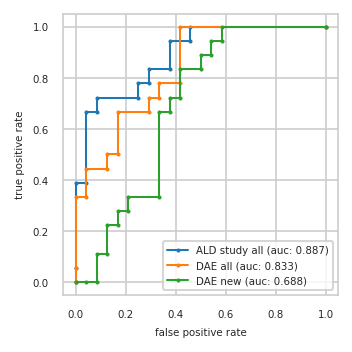

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.333   0.083 0.000
3          0.042 0.389   0.042 0.333   0.083 0.111
4          0.042 0.667   0.042 0.444   0.125 0.111
5          0.083 0.667   0.125 0.444   0.125 0.222
6          0.083 0.722   0.125 0.500   0.167 0.222
7          0.250 0.722   0.167 0.500   0.167 0.278
8          0.250 0.778   0.167 0.667   0.208 0.278
9          0.292 0.778   0.292 0.667   0.208 0.333
10         0.292 0.833   0.292 0.722   0.333 0.333
11         0.375 0.833   0.333 0.722   0.333 0.667
12         0.375 0.944   0.333 0.778   0.375 0.667
13         0.458 0.944   0.417 0.778   0.375 0.722
14         0.458 1.000   0.417 1.000   0.417 0.722
15         1.000 1.000   1.000 1.000   0.417 0.833
16           NaN   NaN     NaN   NaN   0.500 0.833
17           NaN   NaN     NaN   NaN   0.500 0.889
18           NaN   NaN     NaN   NaN   0.542 0.889
19           NaN   NaN     NaN   NaN   0.542 0.944
20           NaN   NaN     NaN   NaN   0.583 0.944
21           NaN   NaN     NaN   NaN   0.583 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,H0YMB1;Q96TC7;Q96TC7-2,P01704
2,P09486,P08670,P51688
3,K7ERG9;P00746,Q9Y2T3;Q9Y2T3-3,P31321
4,P14174,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P10636-2;P10636-6,C9JF17;P05090,Q96GD0
6,P61981,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,Q6EMK4,P61981,Q9NUQ9
8,Q9Y2T3;Q9Y2T3-3,P14174,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


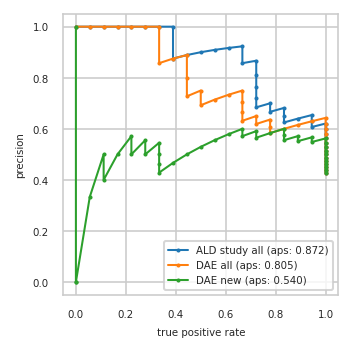

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.562 1.000
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.621 1.000     0.621 1.000     0.552 0.889
14         0.607 0.944     0.643 1.000     0.571 0.889
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.615 0.889     0.577 0.833
17         0.640 0.889     0.600 0.833     0.600 0.833
18         0.625 0.833     0.583 0.778     0.583 0.778
19         0.652 0.833     0.609 0.778     0.565 0.722
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.667 0.778     0.619 0.722     0.571 0.667
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.684 0.722     0.632 0.667     0.579 0.611
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.765 0.722     0.706 0.667     0.529 0.500
26         0.812 0.722     0.750 0.667     0.500 0.444
27         0.867 0.722     0.733 0.611     0.467 0.389
28         0.857 0.667     0.714 0.556     0.429 0.333
29         0.923 0.667     0.692 0.500     0.462 0.333
30         0.917 0.611     0.750 0.500     0.500 0.333
31         0.909 0.556     0.727 0.444     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


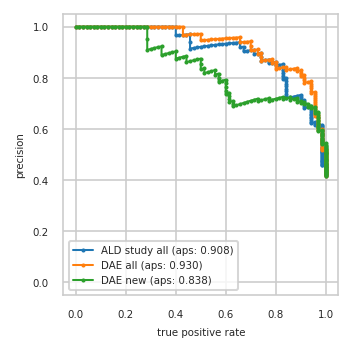

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


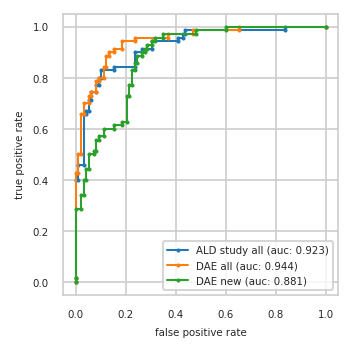

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}